# Emotion classification

## Necessary imports

In [57]:
import os
import json
import random
from itertools import product
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback
)

import torch

## Helper functions

In [2]:
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

In [3]:
def plot_split(dataset, split_name, order):
    df = pd.DataFrame(dataset)
    df['Emotion'] = df['label'].apply(lambda x: labels[x])
    counts = df['Emotion'].value_counts().reindex(order).reset_index()
    counts.columns = ['Emotion','Count']

    sns.set(style="white")
    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=counts, x="Emotion", y="Count", palette="Set2", order=order)
    plt.grid(False)
    for i, r in counts.iterrows():
        ax.text(i, r["Count"]+50, str(r["Count"]), ha='center', va='bottom', fontsize=10)
    plt.title(f"Label Distribution in {split_name} Set")
    plt.xlabel("Emotion"); plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()

## English dataset

### Split dataset

In [4]:
ds_split = load_dataset("dair-ai/emotion", "split")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# labels = ds['train'].features['label'].names
# samples = ds['train'][:10]

# for text, label_id in zip(samples['text'], samples['label']):
#     print(f"Text: {text}")
#     print(f"Label: {labels[label_id]}")
#     print("-" * 60)

In [5]:
print(len(ds_split['train']))

16000


In [6]:
print(len(ds_split['validation']))

2000


In [7]:
print(len(ds_split['test']))

2000


In [8]:
labels = ds_split['train'].features['label'].names
samples = ds_split['train'][:10]

df = pd.DataFrame({
    "text": samples["text"],
    "label": [labels[label_id] for label_id in samples["label"]]
})

df

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


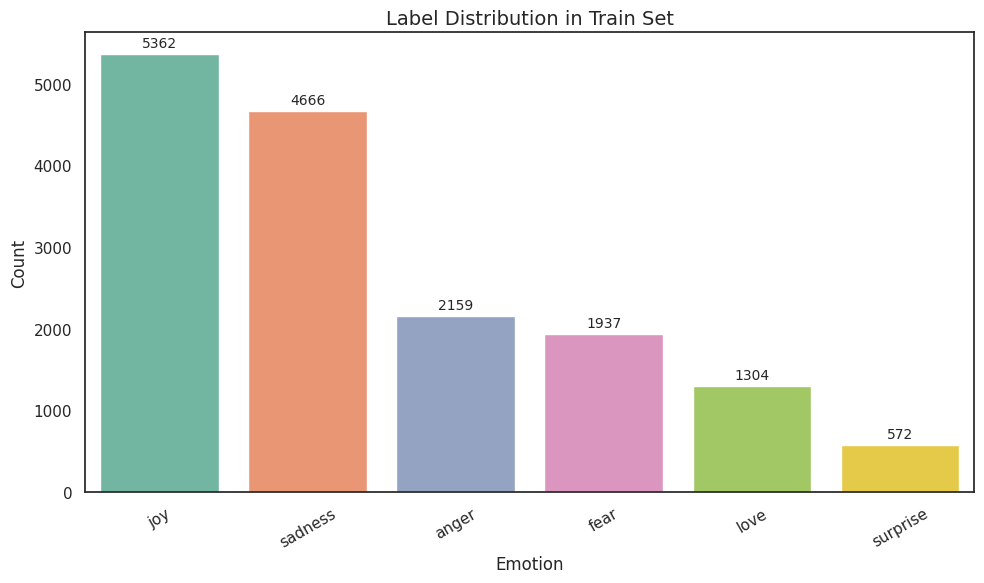

In [9]:
labels = ds_split['train'].features['label'].names
label_counts = Counter([labels[label] for label in ds_split['train']['label']])
sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(sorted_items, columns=["Emotion", "Count"])

sns.set(style="white")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df, x="Emotion", y="Count", palette="Set2")

plt.grid(False)

for i, row in df.iterrows():
    barplot.text(i, row["Count"] + 50, str(row["Count"]), ha='center', va='bottom', fontsize=10)

plt.title("Label Distribution in Train Set", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

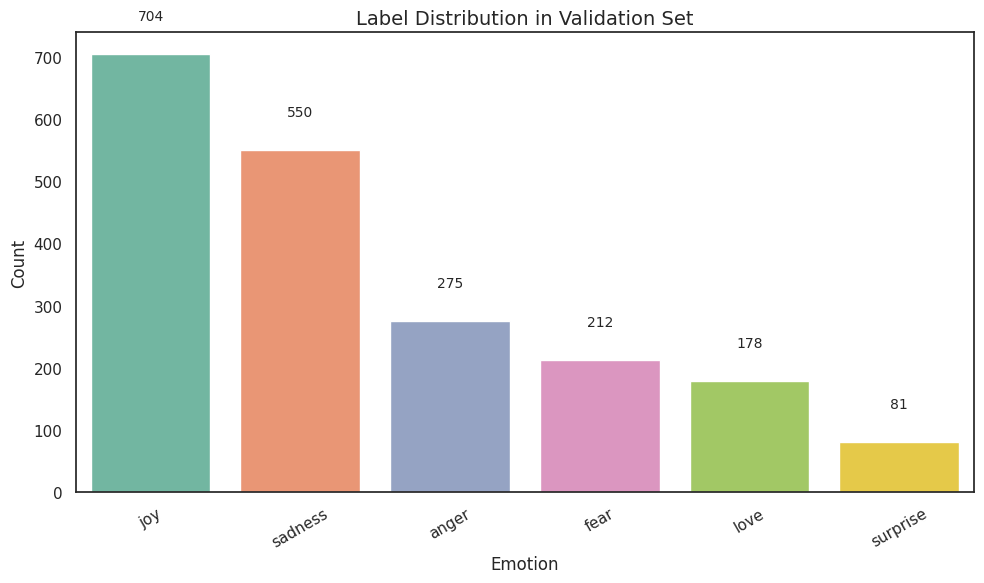

In [10]:
labels = ds_split['validation'].features['label'].names
label_counts = Counter([labels[label] for label in ds_split['validation']['label']])
sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(sorted_items, columns=["Emotion", "Count"])

sns.set(style="white")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df, x="Emotion", y="Count", palette="Set2")

plt.grid(False)

for i, row in df.iterrows():
    barplot.text(i, row["Count"] + 50, str(row["Count"]), ha='center', va='bottom', fontsize=10)

plt.title("Label Distribution in Validation Set", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

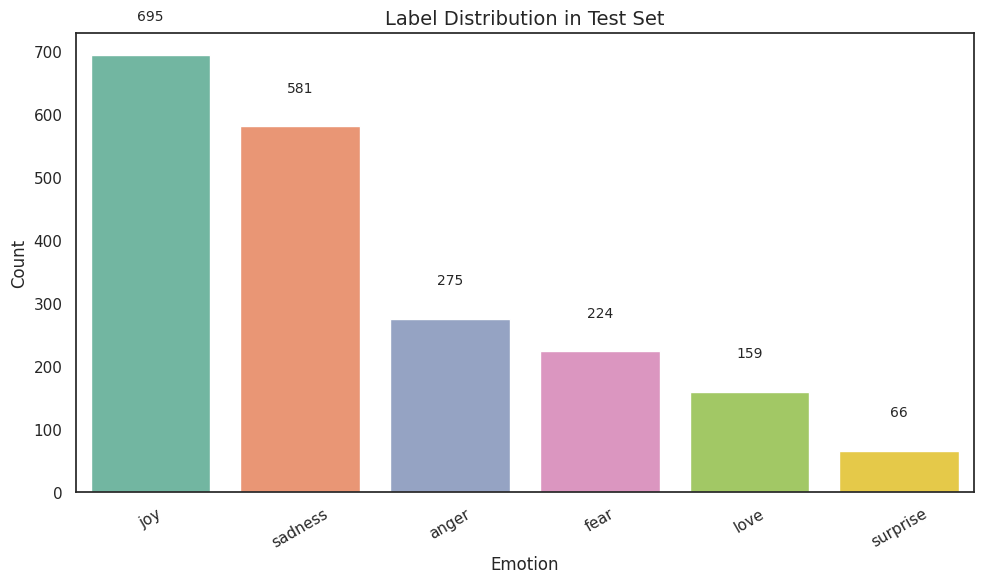

In [11]:
labels = ds_split['test'].features['label'].names
label_counts = Counter([labels[label] for label in ds_split['test']['label']])
sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(sorted_items, columns=["Emotion", "Count"])

sns.set(style="white")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df, x="Emotion", y="Count", palette="Set2")

plt.grid(False)

for i, row in df.iterrows():
    barplot.text(i, row["Count"] + 50, str(row["Count"]), ha='center', va='bottom', fontsize=10)

plt.title("Label Distribution in Test Set", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

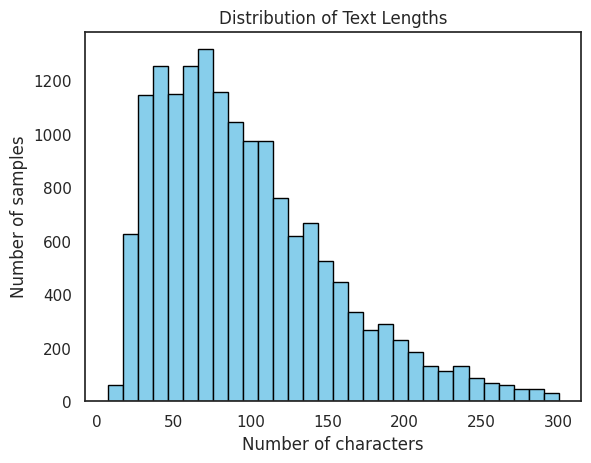

In [12]:
text_lengths = [len(text) for text in ds_split['train']['text']]

plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of characters")
plt.ylabel("Number of samples")
plt.show()

### Unsplit dataset

In [13]:
ds_unsplit = load_dataset("dair-ai/emotion", "unsplit")

train-00000-of-00001.parquet:   0%|          | 0.00/26.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/416809 [00:00<?, ? examples/s]

In [14]:
print(len(ds_unsplit['train']))

416809


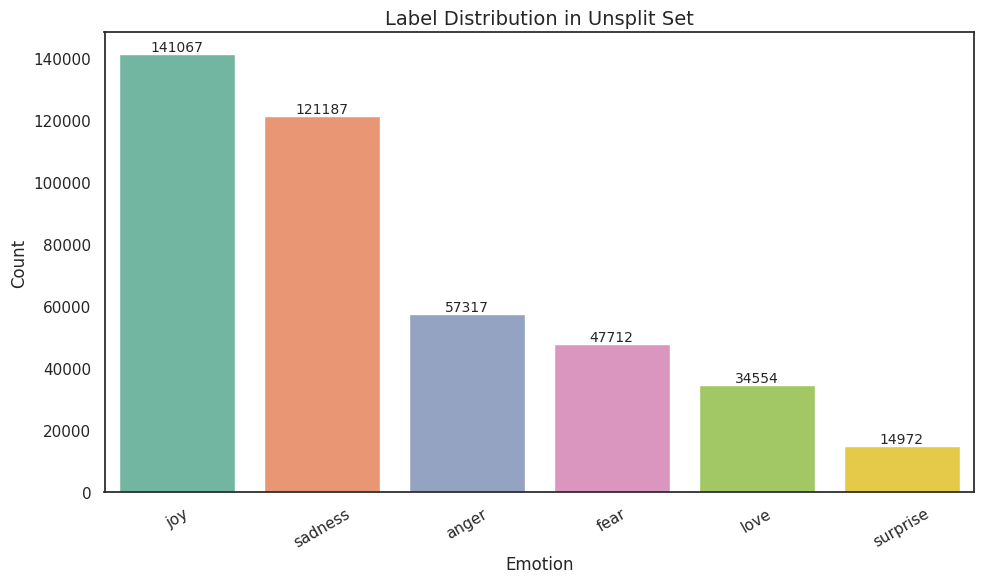

In [15]:
labels = ds_unsplit['train'].features['label'].names
label_counts = Counter([labels[label] for label in ds_unsplit['train']['label']])
sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(sorted_items, columns=["Emotion", "Count"])

sns.set(style="white")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df, x="Emotion", y="Count", palette="Set2")

plt.grid(False)

for i, row in df.iterrows():
    barplot.text(i, row["Count"] + 50, str(row["Count"]), ha='center', va='bottom', fontsize=10)

plt.title("Label Distribution in Unsplit Set", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Data preprocessing: balancing the dataset, checking for duplicates, nans, data leakage...

In [16]:
df = pd.DataFrame(ds_unsplit['train'])
labels = ds_unsplit['train'].features['label'].names

In [17]:
balanced_parts = []
rng = np.random.default_rng(seed=45)

for label_id in range(len(labels)):
    available = df[df['label'] == label_id]
    sample_size = rng.integers(9000, 11001)  # inclusive
    sample_size = min(sample_size, len(available))
    class_samples = available.sample(n=sample_size, random_state=42)
    balanced_parts.append(class_samples)

balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['Emotion'] = balanced_df['label'].apply(lambda x: labels[x])


In [18]:
n_total = len(balanced_df)
n_nan_text = balanced_df["text"].isna().sum()
n_nan_label = balanced_df["label"].isna().sum()
short_mask_all = balanced_df["text"].fillna("").str.split().str.len() < 3
n_short_all = short_mask_all.sum()

print({"rows_total": n_total, "nan_text": int(n_nan_text), "nan_label": int(n_nan_label), "short_texts(<3w)": int(n_short_all)})
if n_nan_text or n_nan_label:
    print(balanced_df[balanced_df["text"].isna() | balanced_df["label"].isna()].head(10)[["text","label"]])
if n_short_all:
    print(balanced_df[short_mask_all][["text","label"]])

{'rows_total': 62107, 'nan_text': 0, 'nan_label': 0, 'short_texts(<3w)': 11}
                    text  label
1601              when i      3
2909             nothing      3
3287               blank      1
10510      sometime back      4
33073             a girl      3
33086               once      4
35882               once      3
45624           honestly      3
46767               when      4
55450  never experienced      3
57641      failing examn      0


In [ ]:
# tmp = balanced_df.dropna(subset=["text","label"]).groupby("text")["label"].nunique().reset_index(name="n_labels")
# conflict_texts = set(tmp.loc[tmp["n_labels"] > 1, "text"])
# conflicts_df = balanced_df[balanced_df["text"].isin(conflict_texts)].sort_values(["text","label"])
# print({"conflicting_texts": len(conflict_texts), "rows_affected": len(conflicts_df)})
# if len(conflicts_df):
#     print(conflicts_df.head(20)[["text","label"]])

In [19]:
mask = balanced_df.duplicated(subset=["text"], keep=False)

duplicates = balanced_df[mask].sort_values("text")
print(f"Number of duplicate texts: {mask.sum()}")
print(duplicates[:20])

Number of duplicate texts: 2047
                                                    text  label   Emotion
17059  i accept aswell been in the abominable bearing...      3     anger
50036  i accept aswell been in the abominable bearing...      4      fear
26672  i admit im feeling a bit lot overwhelmed and s...      5  surprise
5377   i admit im feeling a bit lot overwhelmed and s...      4      fear
23403  i after eli kim but feeling that would maybe b...      5  surprise
36469  i after eli kim but feeling that would maybe b...      4      fear
18765  i album format appeals to me the most but afte...      4      fear
46673  i album format appeals to me the most but afte...      5  surprise
29316  i already own quite a few her smoke rose up fo...      4      fear
50683  i already own quite a few her smoke rose up fo...      5  surprise
38168  i also don t feel like that s the face of some...      2      love
2426   i also don t feel like that s the face of some...      1       joy
24856 

In [20]:
balanced_df = balanced_df.dropna(subset=["text","label"]).copy()

In [21]:
balanced_df = balanced_df[balanced_df["text"].fillna("").str.split().str.len() >= 3]

In [22]:
balanced_df = balanced_df.drop_duplicates(subset=["text"]).reset_index(drop=True)

In [23]:
mask = balanced_df.duplicated(subset=["text"], keep=False)

duplicates = balanced_df[mask].sort_values("text")
print(f"Number of duplicate texts: {mask.sum()}")
print(duplicates[:20])

Number of duplicate texts: 0
Empty DataFrame
Columns: [text, label, Emotion]
Index: []


In [24]:
train_df, temp_df = train_test_split(
    balanced_df,
    test_size=0.30,
    stratify=balanced_df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label'],
    random_state=42
)

splits = {
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True))
}

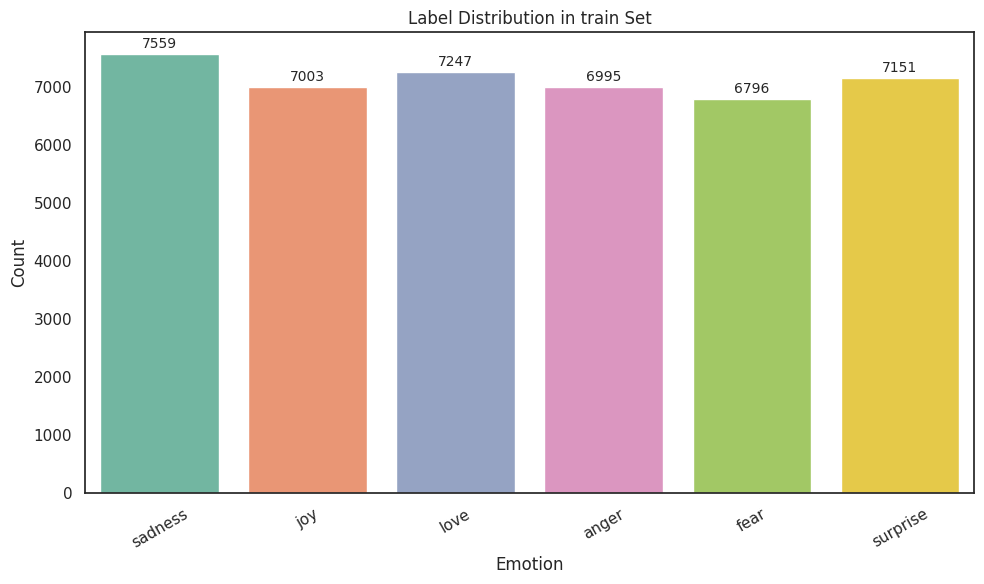

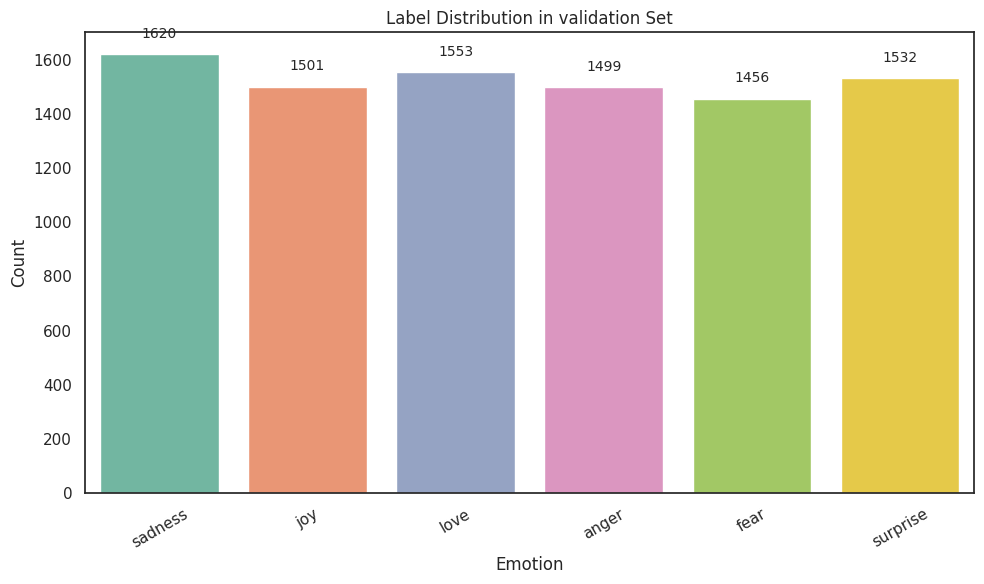

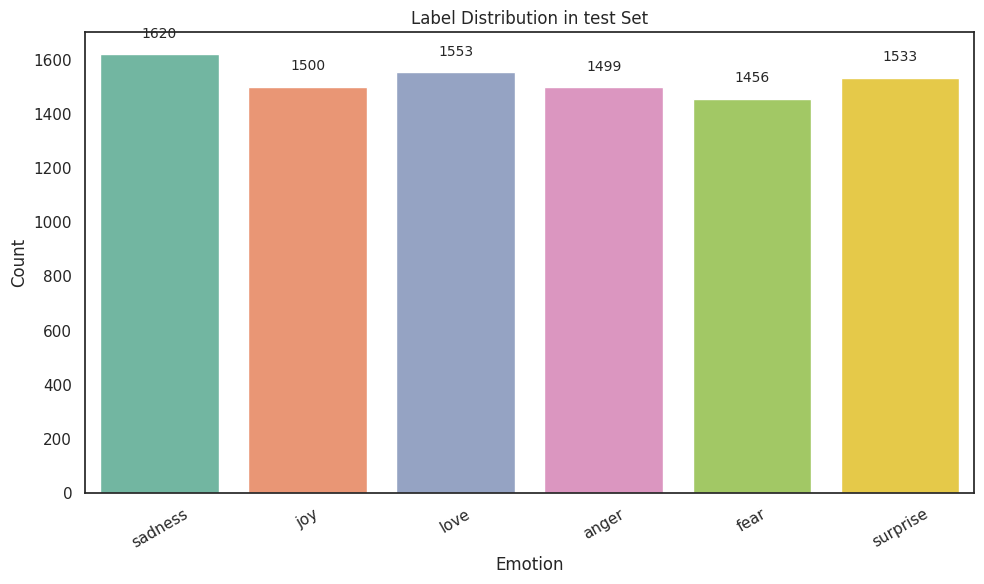

In [25]:
order_labels = labels  # or: sorted(labels)  or: counts.sort_values('Count')['Emotion']
for name, ds_ in splits.items():
    plot_split(ds_, name, order_labels)

In [26]:
train_texts = set(train_df["text"])
val_texts = set(val_df["text"])
test_texts = set(test_df["text"])

overlap_tv = train_texts & val_texts
overlap_tt = train_texts & test_texts
overlap_vt = val_texts & test_texts

print({"leak_train_val": len(overlap_tv), "leak_train_test": len(overlap_tt), "leak_val_test": len(overlap_vt)})
if overlap_tv:
    print("train∩val examples:", list(overlap_tv)[:5])
if overlap_tt:
    print("train∩test examples:", list(overlap_tt)[:5])
if overlap_vt:
    print("val∩test examples:", list(overlap_vt)[:5])

assert len(overlap_tv) == 0 and len(overlap_tt) == 0 and len(overlap_vt) == 0, "Split leakage detected"

{'leak_train_val': 0, 'leak_train_test': 0, 'leak_val_test': 0}


## Model training

#### Hugging Face Datasets

In [27]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

labels_list = labels
class_label = ClassLabel(num_classes=len(labels_list), names=labels_list)

In [28]:
def drop_unused(ds):
    cols = [c for c in ds.column_names if c not in ("text","label")]
    return ds.remove_columns(cols)

In [29]:
train_ds = drop_unused(train_ds).cast_column("label", class_label)
val_ds   = drop_unused(val_ds).cast_column("label", class_label)
test_ds  = drop_unused(test_ds).cast_column("label", class_label)

Casting the dataset:   0%|          | 0/42751 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9161 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9161 [00:00<?, ? examples/s]

In [30]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 42751
})

In [31]:
val_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 9161
})

In [32]:
test_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 9161
})

#### Tokenizing

In [33]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
lengths = pd.Series([len(tokenizer(t, add_special_tokens=True)["input_ids"]) for t in balanced_df["text"]])
p95 = int(lengths.quantile(0.95))
p99 = int(lengths.quantile(0.99))
MAX_LEN = min(256, max(128, p99))

print({"p95": p95, "p99": p99, "MAX_LEN": MAX_LEN})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'p95': 46, 'p99': 58, 'MAX_LEN': 128}


In [34]:
def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

In [35]:
train_tok = train_ds.map(tok, batched=True, remove_columns=["text"])
val_tok   = val_ds.map(tok, batched=True, remove_columns=["text"])
test_tok  = test_ds.map(tok, batched=True, remove_columns=["text"])

Map:   0%|          | 0/42751 [00:00<?, ? examples/s]

Map:   0%|          | 0/9161 [00:00<?, ? examples/s]

Map:   0%|          | 0/9161 [00:00<?, ? examples/s]

In [36]:
train_tok[0]

{'label': 1,
 'input_ids': [101,
  1045,
  2215,
  1037,
  3105,
  2073,
  1045,
  2031,
  2061,
  2172,
  2147,
  2000,
  2079,
  9544,
  8231,
  2242,
  2008,
  1045,
  2572,
  13459,
  2055,
  2004,
  4941,
  2000,
  6945,
  6313,
  25120,
  8518,
  2008,
  2012,
  1996,
  2203,
  1997,
  1996,
  2154,
  1045,
  2514,
  1999,
  5737,
  20255,
  4383,
  1998,
  7568,
  2000,
  2272,
  2067,
  1998,
  11147,
  2009,
  1996,
  2279,
  2154,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


#### Model & metrics definitions

In [37]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels_list))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
labels_list

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [39]:
def compute_metrics(eval_pred, label_list=labels_list):
    preds, y = eval_pred
    preds = np.argmax(preds, axis=1)

    per_class_f1 = {
        f"f1_{label_name}": score
        for label_name, score in zip(
            labels_list,
            f1_score(y, preds, average=None, zero_division=0)
        )
    }

    return {
        "accuracy": accuracy_score(y, preds),
        "f1_macro": f1_score(y, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(y, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(y, preds, average="macro", zero_division=0),
        **per_class_f1
    }

#### Training setup

In [45]:
args = TrainingArguments(
    output_dir="./emotion_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    logging_strategy="steps",
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

In [46]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [47]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.158600,0.124161,0.957647,0.957182,0.958030,0.957131,0.963078,0.953393,0.965799,0.955405,0.932409,0.973007
2,0.108100,0.109778,0.961249,0.960762,0.961758,0.960781,0.968995,0.958706,0.968995,0.959656,0.934593,0.973626
3,0.093900,0.114763,0.960594,0.960170,0.961135,0.960080,0.966202,0.959478,0.968995,0.959620,0.933425,0.973299
4,0.073100,0.111525,0.962340,0.961941,0.962796,0.961915,0.969716,0.959478,0.968348,0.963087,0.937716,0.973299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2672, training_loss=0.1768285430477051, metrics={'train_runtime': 1189.1216, 'train_samples_per_second': 143.807, 'train_steps_per_second': 2.247, 'total_flos': 5015296774394928.0, 'train_loss': 0.1768285430477051, 'epoch': 4.0})

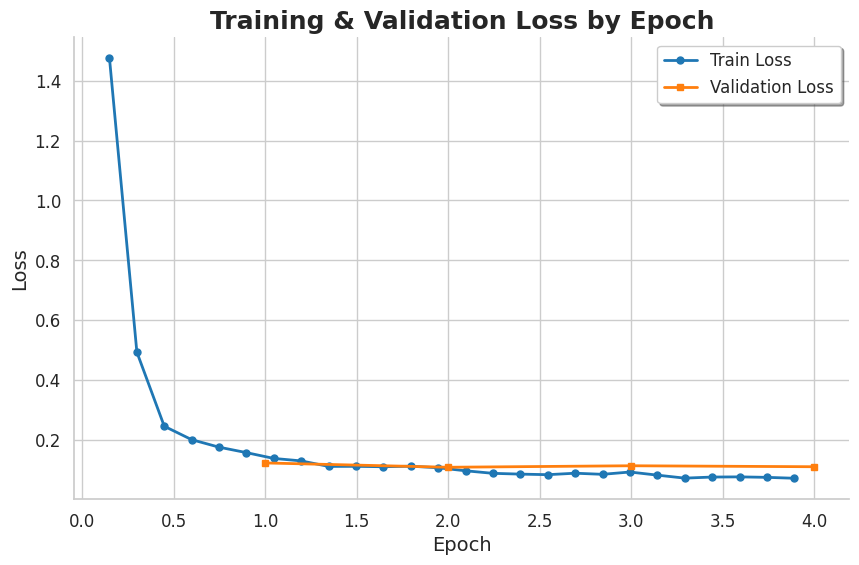

In [49]:
logs = pd.DataFrame(trainer.state.log_history)

train_logs = logs[logs["loss"].notnull()][["epoch", "loss"]]
val_logs = logs[logs["eval_loss"].notnull()][["epoch", "eval_loss"]]

sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

# Плот по епохах
plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss", 
         color="#1f77b4", linewidth=2, marker="o", markersize=5)
plt.plot(val_logs["epoch"], val_logs["eval_loss"], label="Validation Loss", 
         color="#ff7f0e", linewidth=2, marker="s", markersize=5)

plt.title("Training & Validation Loss by Epoch", fontsize=18, fontweight="bold")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=True, shadow=True, fontsize=12)

sns.despine()
plt.show()

In [51]:
# val_metrics = trainer.evaluate(eval_dataset=val_tok)
test_metrics = trainer.evaluate(eval_dataset=test_tok)
trainer.save_model("./emotion_bert/best")
tokenizer.save_pretrained("./emotion_bert/best")
print({"test": test_metrics})

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test': {'eval_loss': 0.10684368759393692, 'eval_accuracy': 0.9628861478004584, 'eval_f1_macro': 0.9625295520305831, 'eval_precision_macro': 0.963544999267112, 'eval_recall_macro': 0.9625161912478007, 'eval_f1_sadness': 0.9690721649484536, 'eval_f1_joy': 0.9539951573849879, 'eval_f1_love': 0.9678225554514215, 'eval_f1_anger': 0.9639278557114228, 'eval_f1_fear': 0.9470771359391215, 'eval_f1_surprise': 0.9732824427480915, 'eval_runtime': 19.2683, 'eval_samples_per_second': 475.443, 'eval_steps_per_second': 3.737, 'epoch': 4.0}}


In [52]:
pred = trainer.predict(test_tok)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=labels_list))
cm = confusion_matrix(y_true, y_pred)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

     sadness       0.98      0.96      0.97      1620
         joy       0.99      0.92      0.95      1500
        love       0.94      1.00      0.97      1553
       anger       0.97      0.96      0.96      1499
        fear       0.95      0.94      0.95      1456
    surprise       0.95      1.00      0.97      1533

    accuracy                           0.96      9161
   macro avg       0.96      0.96      0.96      9161
weighted avg       0.96      0.96      0.96      9161



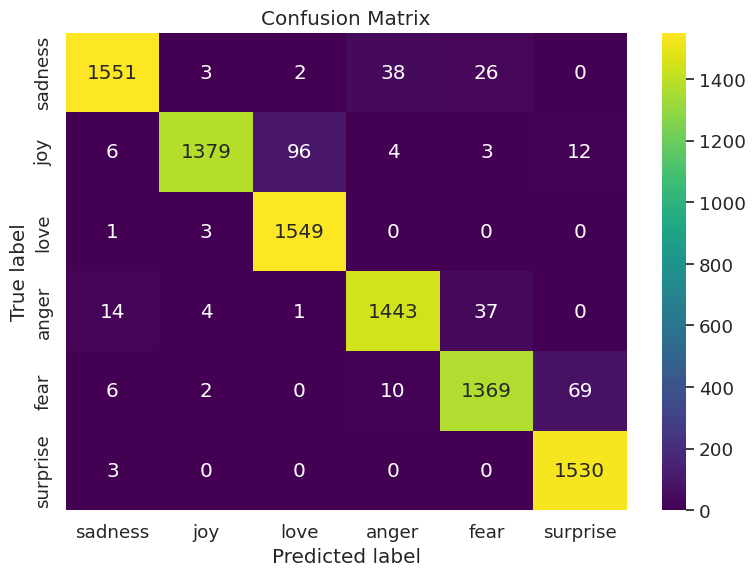

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=labels_list,
    yticklabels=labels_list
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [54]:
def predict_emotion(texts, topk=3):
    if isinstance(texts, str):
        texts = [texts]
    enc = tokenizer(texts, truncation=True, max_length=MAX_LEN, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    topk_idx = np.argsort(-probs, axis=1)[:, :topk]
    results = []
    for i, idxs in enumerate(topk_idx):
        results.append([(labels_list[j], float(probs[i, j])) for j in idxs])
    return results

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
text = "My cat died"
res = predict_emotion(text, topk=3)[0]
print(text)
print(res)
for lbl, p in res:
    print(f"{lbl}: {p:.3f}")

My cat died
[('sadness', 0.9879530072212219), ('anger', 0.009996132925152779), ('joy', 0.001094358623959124)]
sadness: 0.988
anger: 0.010
joy: 0.001


## Choosing the best weight decays and learning rate parameters

In [60]:
def plot_losses(trainer, run_dir, run_name):
    logs = pd.DataFrame(trainer.state.log_history)
    train_logs = (
        logs.loc[logs["loss"].notnull(), ["epoch", "loss"]]
        .dropna()
        .groupby("epoch", as_index=False)
        .mean()
        .sort_values("epoch")
    )
    val_logs = (
        logs.loc[logs["eval_loss"].notnull(), ["epoch", "eval_loss"]]
        .dropna()
        .groupby("epoch", as_index=False)
        .last()
        .sort_values("epoch")
    )
    os.makedirs(os.path.join(run_dir, "plots"), exist_ok=True)
    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))
    if len(train_logs):
        plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss", linewidth=2, marker="o", markersize=4)
    if len(val_logs):
        plt.plot(val_logs["epoch"], val_logs["eval_loss"], label="Validation Loss", linewidth=2, marker="s", markersize=4)
    plt.title("Training & Validation Loss by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if len(train_logs) or len(val_logs):
        plt.legend()
    sns.despine()
    plt.tight_layout()
    path = os.path.join(run_dir, "plots", f"{run_name}_loss.png")
    plt.savefig(path, dpi=150)
    plt.show()
    train_logs.to_csv(os.path.join(run_dir, "plots", f"{run_name}_train_logs.csv"), index=False)
    val_logs.to_csv(os.path.join(run_dir, "plots", f"{run_name}_val_logs.csv"), index=False)

def plot_confusion_matrix(cm, labels, run_dir, run_name):
    os.makedirs(os.path.join(run_dir, "plots"), exist_ok=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    path = os.path.join(run_dir, "plots", f"{run_name}_confusion_matrix.png")
    plt.savefig(path, dpi=150)
    plt.show()
    # plt.close()

def evaluate_and_save(trainer, test_dataset, labels, run_dir, run_name):
    pred = trainer.predict(test_dataset)
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
    with open(os.path.join(run_dir, f"{run_name}_classification_report.json"), "w") as f:
        json.dump(report, f, indent=2)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(run_dir, f"{run_name}_classification_report.csv"))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels, run_dir, run_name)

def strip_prefix(d, prefix="eval_"):
    return {k[len(prefix):]: v for k, v in d.items() if k.startswith(prefix)}

MODEL_NAME = "bert-base-uncased"

ID2LABEL = {i: name for i, name in enumerate(labels_list)}
LABEL2ID = {name: i for i, name in enumerate(labels_list)}
NUM_LABELS = len(labels_list)

def build_model():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        id2label=ID2LABEL,
        label2id=LABEL2ID,
    )

In [61]:
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, tokenizer, metric="eval_f1_macro", greater_is_better=True):
        self.tokenizer = tokenizer
        self.metric = metric
        self.greater = greater_is_better
        self.best = None
        self.best_dir = None
    def on_evaluate(self, args, state, control, **kwargs):
        val = kwargs.get("metrics", {}).get(self.metric)
        if val is None:
            return
        better = (self.best is None) or (val > self.best if self.greater else val < self.best)
        if better:
            self.best = val
            self.best_dir = os.path.join(args.output_dir, "best")
            os.makedirs(self.best_dir, exist_ok=True)
            kwargs["model"].save_pretrained(self.best_dir)
            self.tokenizer.save_pretrained(self.best_dir)
        setattr(state, "best_metric_callback", self.best)
        setattr(state, "best_dir", self.best_dir)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.232300,0.171880,0.948586,0.947934,0.949296,0.947810,0.952322,0.939842,0.956657,0.947861,0.920782,0.970140
2,0.143000,0.128689,0.957756,0.957189,0.958366,0.957251,0.968269,0.953200,0.965517,0.954158,0.930233,0.971755
3,0.119200,0.119508,0.959939,0.959526,0.960460,0.959497,0.967280,0.957476,0.967742,0.958177,0.934111,0.972372
4,0.094600,0.114743,0.961249,0.960834,0.961664,0.960856,0.970856,0.959149,0.968025,0.959596,0.934387,0.972990


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


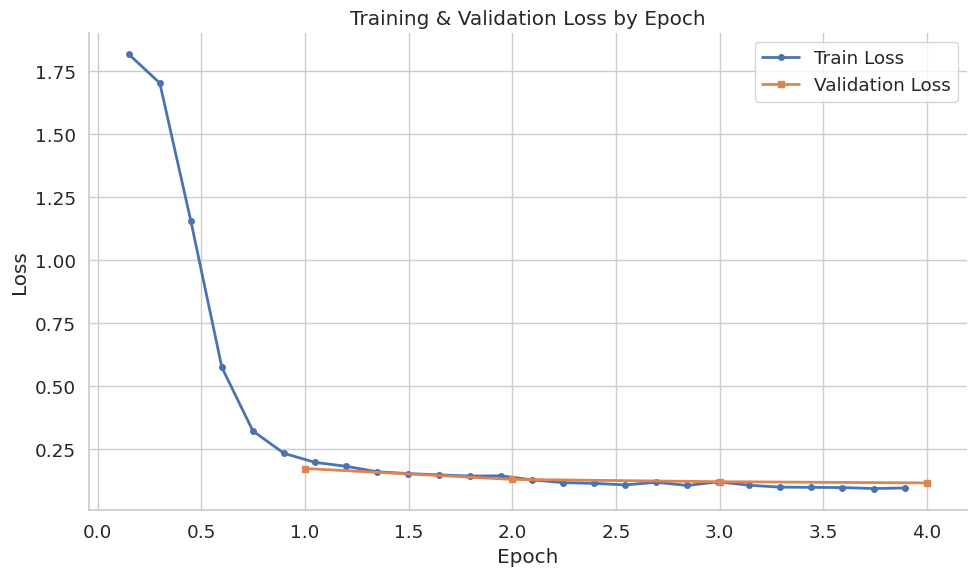

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


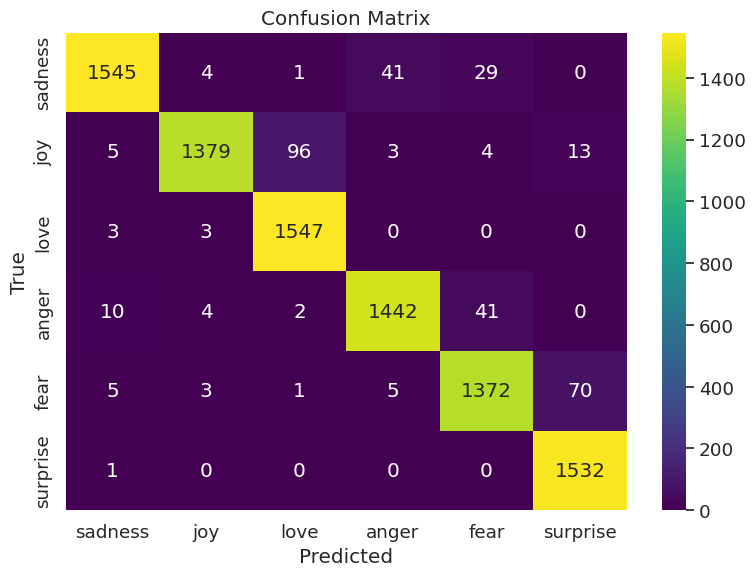

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.233200,0.172153,0.948696,0.948033,0.949472,0.947910,0.952030,0.940083,0.956657,0.947965,0.920669,0.970794
2,0.142900,0.128304,0.957756,0.957197,0.958367,0.957262,0.968553,0.953889,0.965215,0.953816,0.929954,0.971755
3,0.118700,0.119590,0.960048,0.959628,0.960520,0.959608,0.967581,0.957177,0.968045,0.957852,0.934432,0.972681
4,0.094900,0.114743,0.961140,0.960715,0.961548,0.960729,0.970588,0.958104,0.968329,0.959892,0.934387,0.972990


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


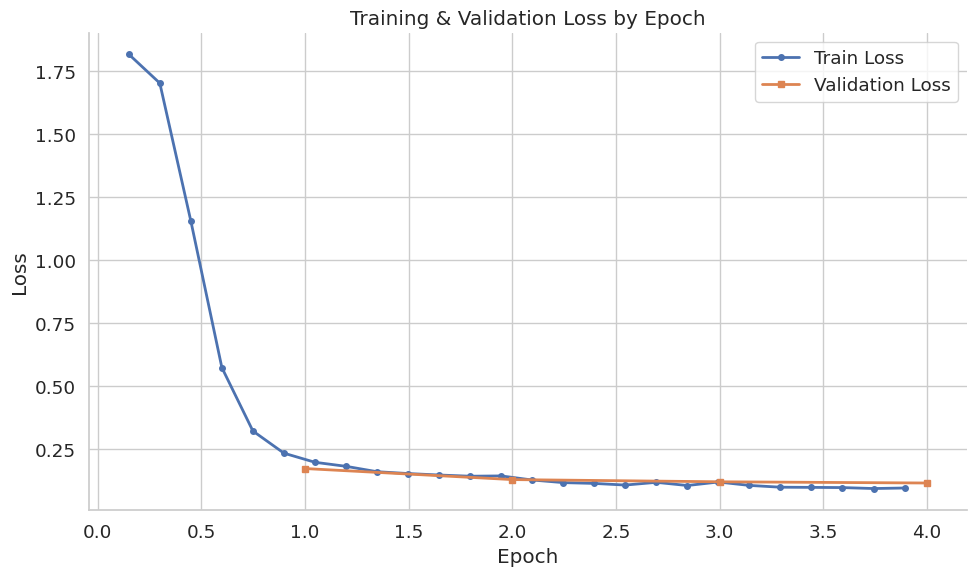

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


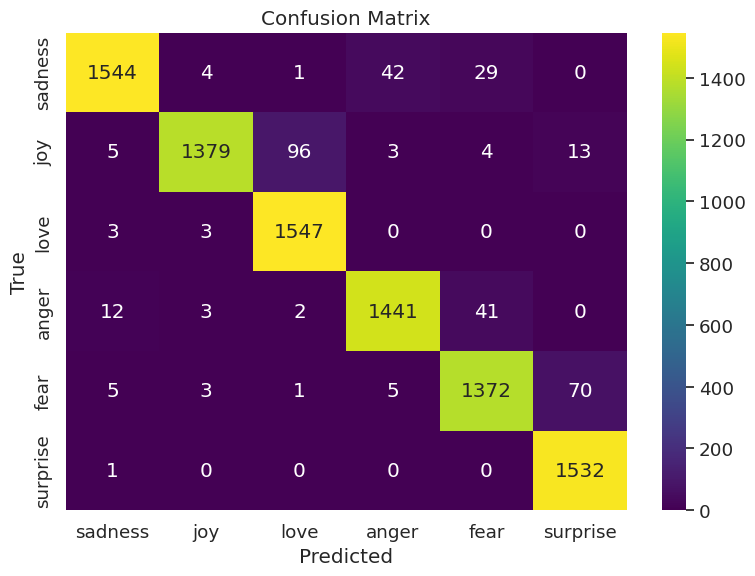

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.233500,0.172474,0.948041,0.947339,0.948875,0.947212,0.951767,0.938705,0.956711,0.947368,0.919343,0.970140
2,0.142600,0.128567,0.958083,0.957535,0.958755,0.957583,0.968269,0.954874,0.965539,0.954471,0.930609,0.971447
3,0.118900,0.119826,0.959393,0.958984,0.959911,0.958954,0.965431,0.957148,0.967742,0.957143,0.934066,0.972372
4,0.095100,0.115001,0.960921,0.960494,0.961324,0.960515,0.970570,0.957775,0.968025,0.959218,0.934387,0.972990


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


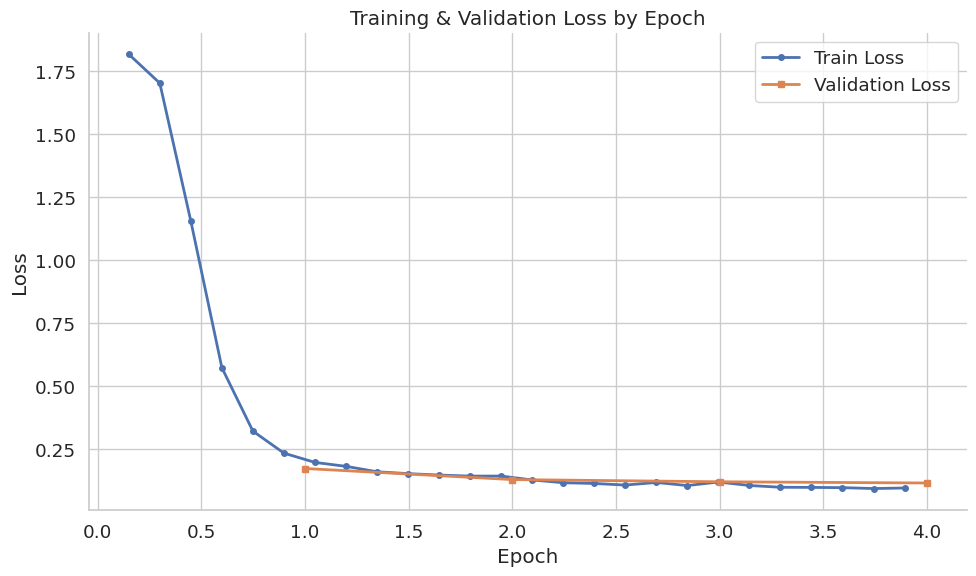

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


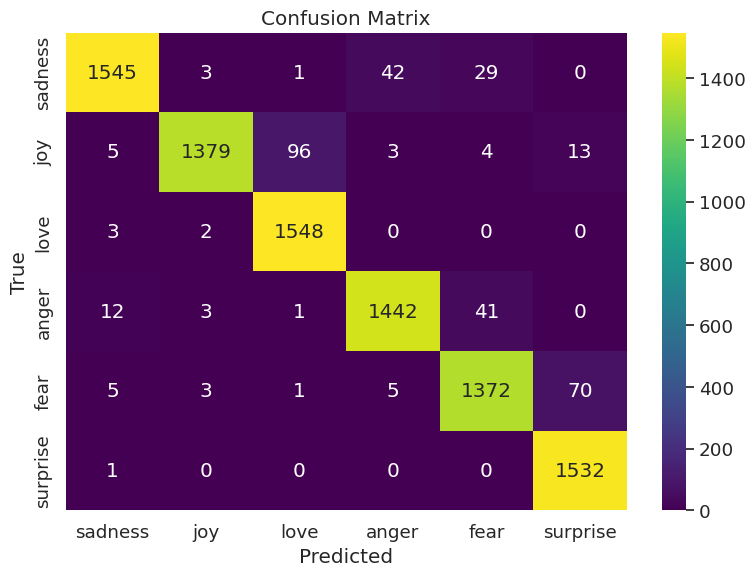

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.167700,0.144142,0.954808,0.954285,0.955194,0.954312,0.963357,0.943667,0.960125,0.957633,0.929194,0.971737
2,0.111100,0.113815,0.960921,0.960378,0.961449,0.960355,0.970340,0.959780,0.968995,0.958995,0.931786,0.972372
3,0.098000,0.111773,0.960812,0.960398,0.961314,0.960362,0.968224,0.959177,0.968691,0.956935,0.936683,0.972681
4,0.075700,0.110242,0.963323,0.962931,0.963817,0.962928,0.972144,0.960413,0.968975,0.964824,0.937931,0.973299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


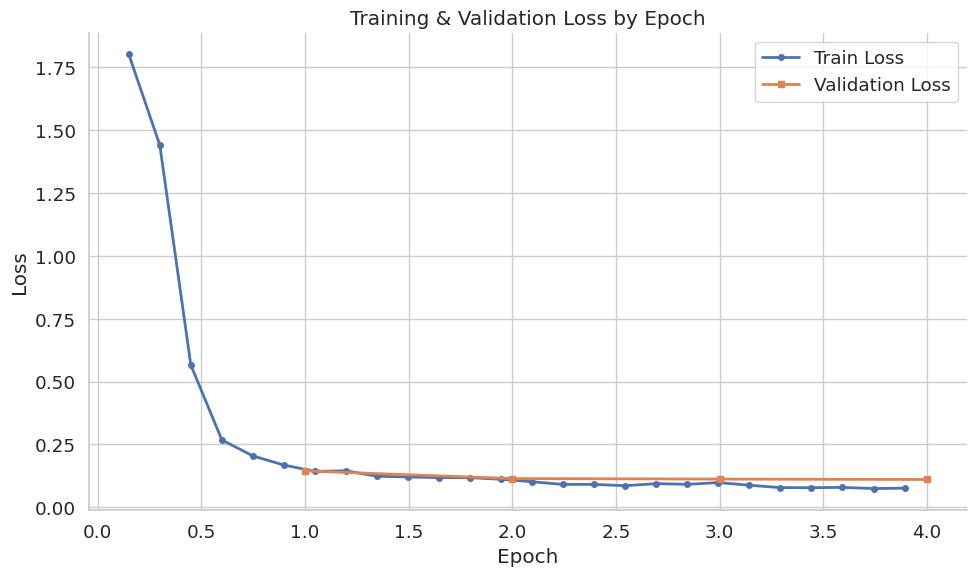

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


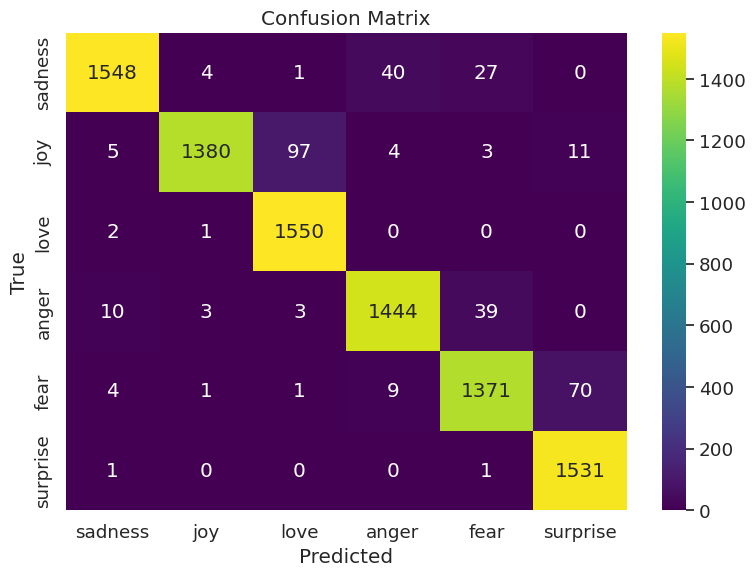

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.170000,0.140170,0.955573,0.955044,0.955911,0.955052,0.962570,0.943912,0.962523,0.958040,0.930866,0.972355
2,0.110900,0.115695,0.961030,0.960529,0.961548,0.960518,0.970947,0.957241,0.967742,0.960531,0.934031,0.972681
3,0.096000,0.114461,0.959830,0.959404,0.960237,0.959370,0.966418,0.957177,0.968005,0.955254,0.936273,0.973299
4,0.075000,0.109900,0.962340,0.961935,0.962840,0.961927,0.971250,0.958980,0.968348,0.962739,0.936683,0.973609


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


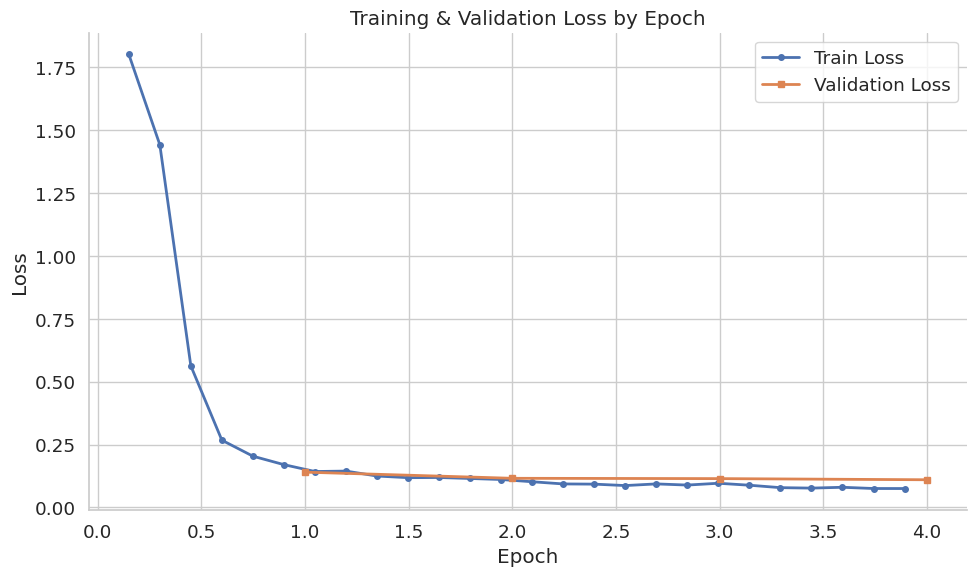

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


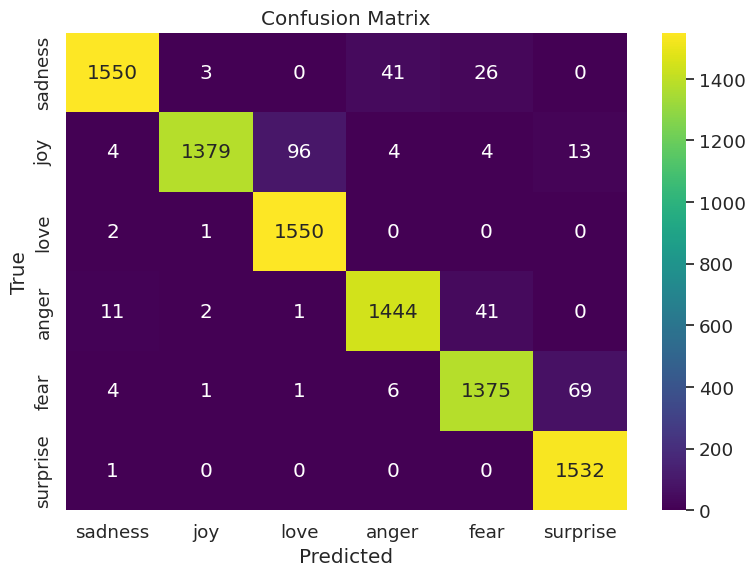

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.167900,0.141472,0.954699,0.954194,0.955204,0.954156,0.960149,0.946863,0.960748,0.956639,0.929046,0.971719
2,0.110900,0.112220,0.961467,0.961022,0.961973,0.961002,0.970322,0.958649,0.968065,0.961230,0.935182,0.972681
3,0.095600,0.109932,0.960594,0.960183,0.961134,0.960116,0.966760,0.960522,0.968995,0.955548,0.936595,0.972681
4,0.075700,0.106948,0.963432,0.963041,0.963884,0.963052,0.971500,0.960110,0.969583,0.966510,0.937241,0.973299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


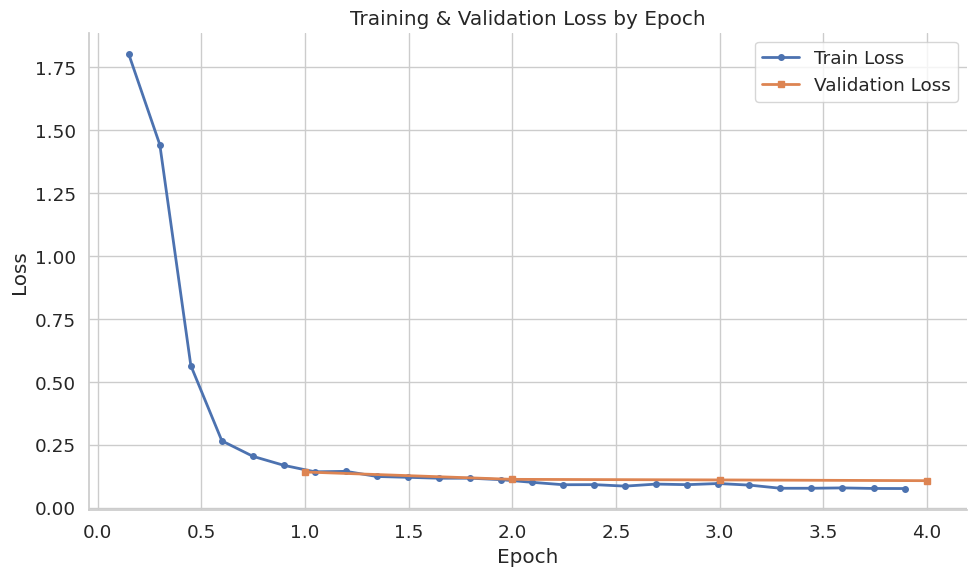

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


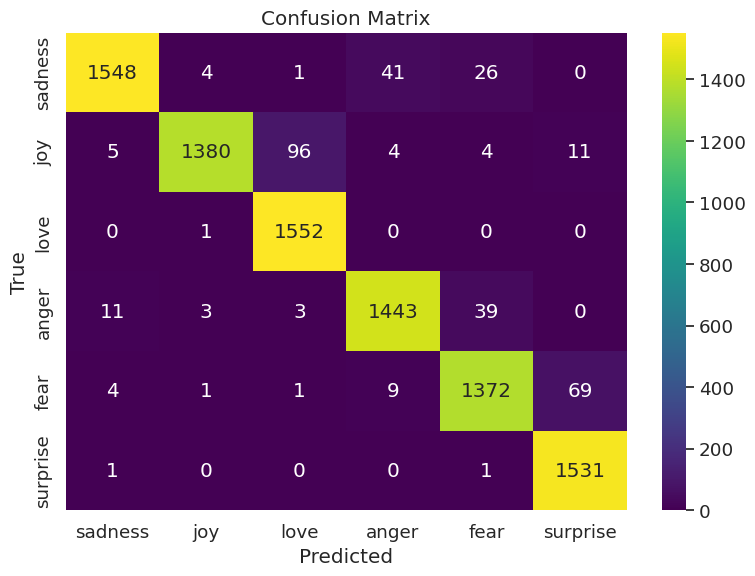

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.146800,0.126008,0.958629,0.958139,0.958862,0.958213,0.970135,0.949406,0.967480,0.956964,0.933150,0.971701
2,0.101100,0.096626,0.964414,0.963965,0.964872,0.964024,0.977008,0.960798,0.969583,0.964924,0.937543,0.973935
3,0.090500,0.103252,0.964305,0.963939,0.964803,0.963946,0.973973,0.961591,0.970551,0.964912,0.939924,0.972681
4,0.072400,0.110408,0.963978,0.963584,0.964386,0.963556,0.972517,0.962938,0.969545,0.963807,0.938451,0.974245


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


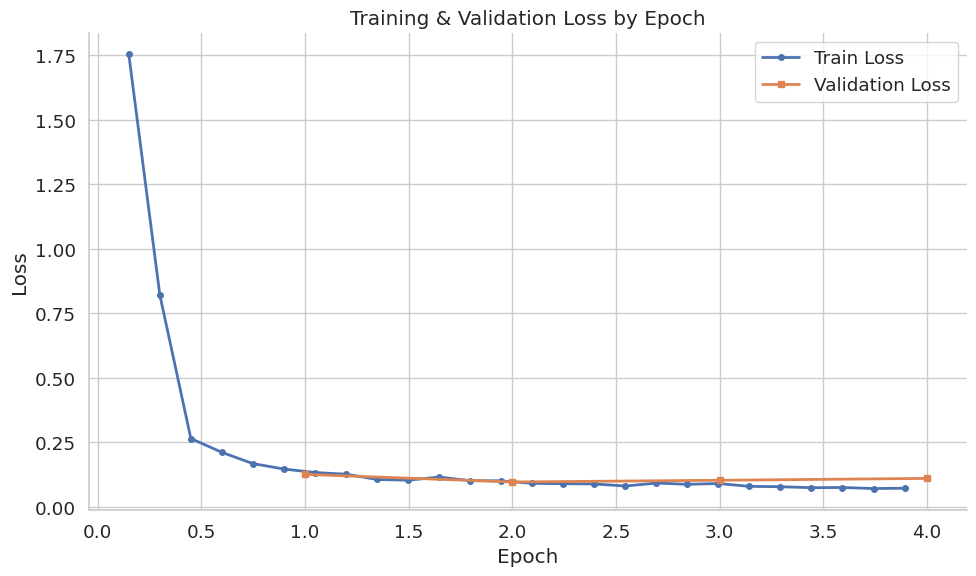

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


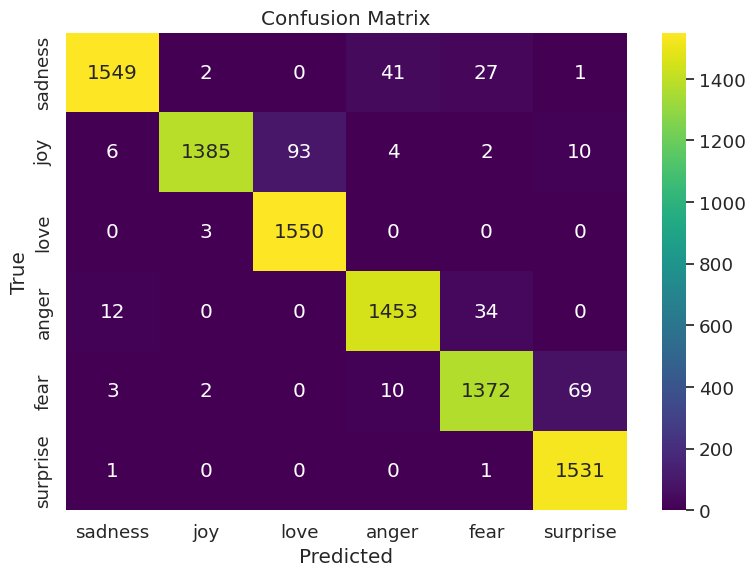

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.150800,0.120594,0.958520,0.958062,0.958896,0.958162,0.968474,0.949129,0.965066,0.957490,0.934895,0.973316
2,0.105200,0.101435,0.963541,0.963134,0.964097,0.963194,0.973858,0.961379,0.970588,0.963260,0.936404,0.973316
3,0.090900,0.109168,0.961358,0.960916,0.961779,0.960832,0.967122,0.960301,0.970514,0.961708,0.932549,0.973299
4,0.071100,0.112121,0.963650,0.963258,0.964013,0.963261,0.970588,0.961288,0.969868,0.966209,0.937673,0.973919


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


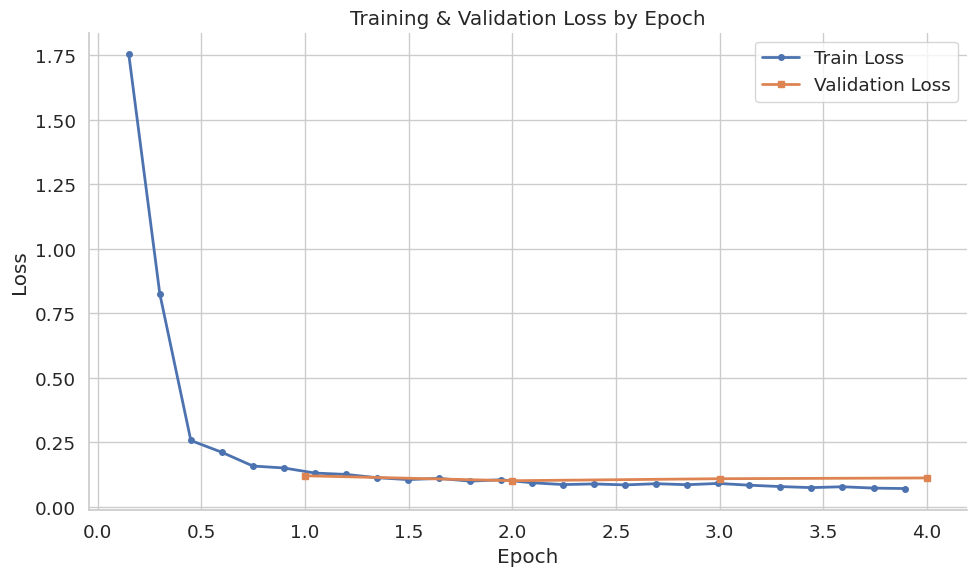

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


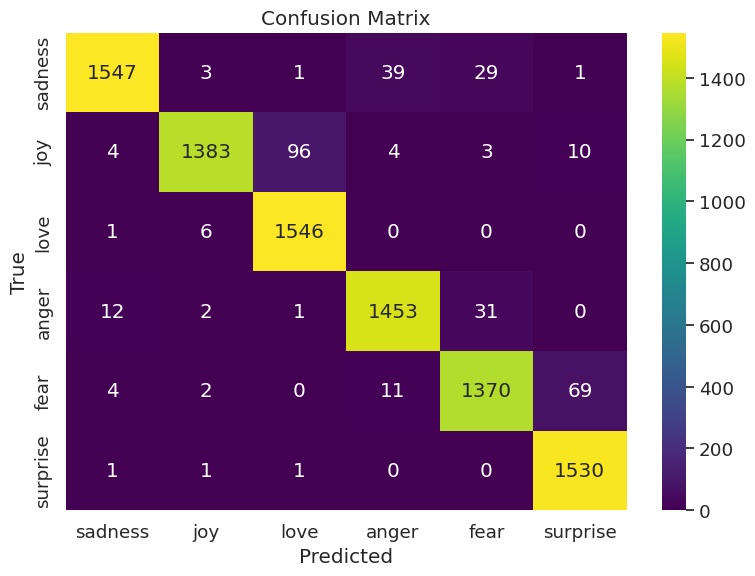

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/699579558.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.149900,0.131243,0.957428,0.956939,0.957590,0.957014,0.965820,0.947903,0.967378,0.955842,0.932320,0.972372
2,0.102700,0.097766,0.965397,0.964965,0.965872,0.965017,0.976686,0.963243,0.971196,0.967142,0.937587,0.973935
3,0.090100,0.108157,0.963214,0.962815,0.963609,0.962798,0.969413,0.959316,0.971482,0.963839,0.938902,0.973935
4,0.072500,0.116262,0.962995,0.962559,0.963412,0.962562,0.970588,0.960852,0.970892,0.963509,0.935596,0.973919


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


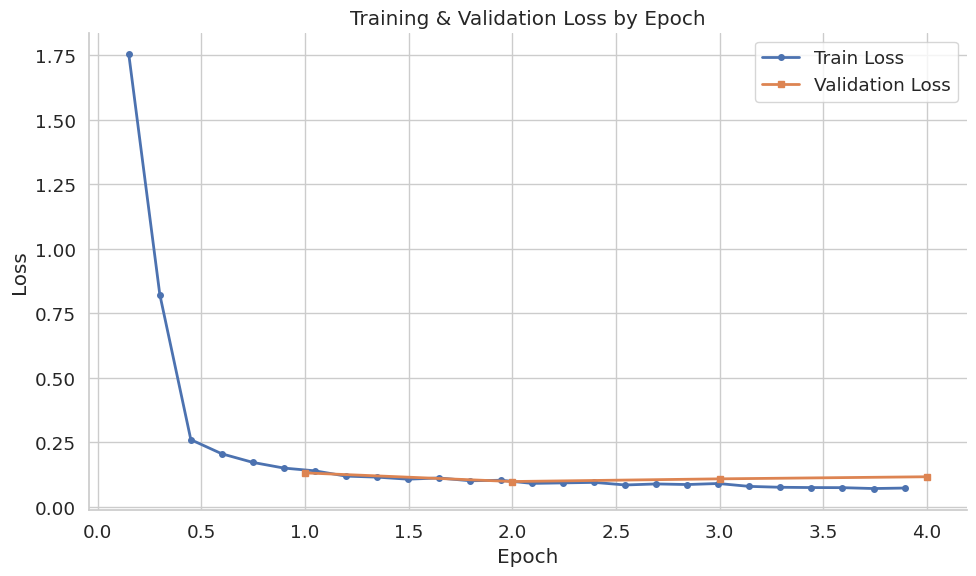

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


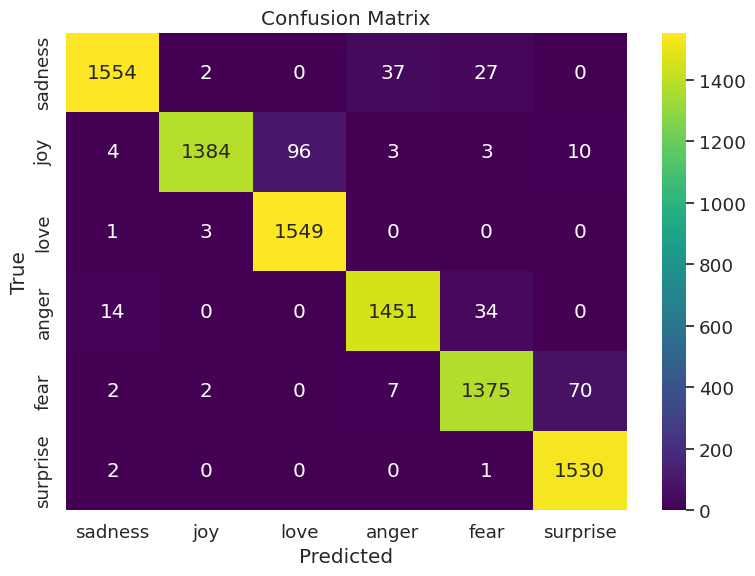

/tmp/ipykernel_36/699579558.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/699579558.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [63]:
# will rerun this cell to add test_best_ and test_final_ metrics
def add_prefix(d, prefix):
    return {f"{prefix}{k}": v for k, v in d.items()}

learning_rates = [1e-5, 2e-5, 5e-5]
weight_decays = [0.01, 0.05, 0.1]
records = []

for lr, wd in product(learning_rates, weight_decays):
    run_name = f"lr{lr}_wd{wd}"
    out_dir = f"./emotion_bert_{run_name}"

    args = TrainingArguments(
        output_dir=out_dir,
        evaluation_strategy="epoch",
        save_strategy="no",
        save_total_limit=1,
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        num_train_epochs=4,
        weight_decay=wd,
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        logging_strategy="steps",
        logging_steps=100,
        seed=42,
        fp16=torch.cuda.is_available(),
        report_to="none",
        disable_tqdm=False
    )

    cb = SaveBestModelCallback(tokenizer=tokenizer, metric="eval_f1_macro", greater_is_better=True)

    trainer = Trainer(
        model=build_model(),
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[cb]
    )

    trainer.train()

    val_metrics = strip_prefix(trainer.evaluate(), "eval_")
    plot_losses(trainer, out_dir, run_name)
    evaluate_and_save(trainer, test_tok, labels_list, out_dir, run_name)

    final_dir = os.path.join(out_dir, "final")
    os.makedirs(final_dir, exist_ok=True)
    trainer.save_model(final_dir)
    tokenizer.save_pretrained(final_dir)

    best_dir = getattr(trainer.state, "best_dir", None)
    best_val_f1 = getattr(trainer.state, "best_metric_callback", None)
    final_val_f1 = val_metrics.get("f1_macro", None)

    final_model = AutoModelForSequenceClassification.from_pretrained(final_dir)
    final_eval_trainer = Trainer(
        model=final_model,
        args=args,
        eval_dataset=test_tok,
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    final_test_metrics = strip_prefix(final_eval_trainer.evaluate(), "eval_")

    if best_dir is not None and os.path.isdir(best_dir):
        best_model = AutoModelForSequenceClassification.from_pretrained(best_dir)
        best_eval_trainer = Trainer(
            model=best_model,
            args=args,
            eval_dataset=test_tok,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        best_test_metrics = strip_prefix(best_eval_trainer.evaluate(), "eval_")
    else:
        best_test_metrics = {}

    records.append({
        "learning_rate": lr,
        "weight_decay": wd,
        "best_dir": best_dir,
        "final_dir": final_dir,
        "best_val_f1": best_val_f1,
        "final_val_f1": final_val_f1,
        **add_prefix(val_metrics, "val_"),
        **add_prefix(best_test_metrics, "test_best_"),
        **add_prefix(final_test_metrics, "test_final_"),
    })

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [64]:
df = pd.DataFrame(records).sort_values(
    by=["best_test_f1", "final_test_f1", "best_val_f1", "final_val_f1"],
    ascending=False
).reset_index(drop=True)
df.to_csv("grid_results.csv", index=False)
# print(df.head(10))

   learning_rate  weight_decay                            best_dir  \
0        0.00005          0.10   ./emotion_bert_lr5e-05_wd0.1/best   
1        0.00005          0.01  ./emotion_bert_lr5e-05_wd0.01/best   
2        0.00002          0.05  ./emotion_bert_lr2e-05_wd0.05/best   
3        0.00005          0.05  ./emotion_bert_lr5e-05_wd0.05/best   
4        0.00002          0.10   ./emotion_bert_lr2e-05_wd0.1/best   
5        0.00002          0.01  ./emotion_bert_lr2e-05_wd0.01/best   
6        0.00001          0.10   ./emotion_bert_lr1e-05_wd0.1/best   
7        0.00001          0.01  ./emotion_bert_lr1e-05_wd0.01/best   
8        0.00001          0.05  ./emotion_bert_lr1e-05_wd0.05/best   

                             final_dir  best_val_f1  final_val_f1  \
0   ./emotion_bert_lr5e-05_wd0.1/final     0.964965      0.962559   
1  ./emotion_bert_lr5e-05_wd0.01/final     0.963965      0.963584   
2  ./emotion_bert_lr2e-05_wd0.05/final     0.961935      0.961935   
3  ./emotion_bert_lr5e-

In [65]:
df

,learning_rate,weight_decay,best_dir,final_dir,best_val_f1,final_val_f1,best_test_f1,final_test_f1,loss,accuracy,...,recall_macro,f1_sadness,f1_joy,f1_love,f1_anger,f1_fear,f1_surprise,runtime,samples_per_second,steps_per_second
0,0.00005,0.10,./emotion_bert_lr5e-05_wd0.1/best,./emotion_bert_lr5e-05_wd0.1/final,0.964965,0.962559,0.964387,0.964971,0.116262,0.962995,...,0.962562,0.970588,0.960852,0.970892,0.963509,0.935596,0.973919,19.0632,480.558,3.777
1,0.00005,0.01,./emotion_bert_lr5e-05_wd0.01/best,./emotion_bert_lr5e-05_wd0.01/final,0.963965,0.963584,0.964045,0.964631,0.110408,0.963978,...,0.963556,0.972517,0.962938,0.969545,0.963807,0.938451,0.974245,19.1989,477.162,3.750
2,0.00002,0.05,./emotion_bert_lr2e-05_wd0.05/best,./emotion_bert_lr2e-05_wd0.05/final,0.961935,0.961935,0.963520,0.963520,0.109900,0.962340,...,0.961927,0.971250,0.958980,0.968348,0.962739,0.936683,0.973609,19.0726,480.322,3.775
3,0.00005,0.05,./emotion_bert_lr5e-05_wd0.05/best,./emotion_bert_lr5e-05_wd0.05/final,0.963258,0.963258,0.963433,0.963433,0.112121,0.963650,...,0.963261,0.970588,0.961288,0.969868,0.966209,0.937673,0.973919,19.1867,477.466,3.753
4,0.00002,0.10,./emotion_bert_lr2e-05_wd0.1/best,./emotion_bert_lr2e-05_wd0.1/final,0.963041,0.963041,0.963072,0.963072,0.106948,0.963432,...,0.963052,0.971500,0.960110,0.969583,0.966510,0.937241,0.973299,19.1416,478.592,3.761
5,0.00002,0.01,./emotion_bert_lr2e-05_wd0.01/best,./emotion_bert_lr2e-05_wd0.01/final,0.962931,0.962931,0.962863,0.962863,0.110242,0.963323,...,0.962928,0.972144,0.960413,0.968975,0.964824,0.937931,0.973299,19.0593,480.659,3.778
6,0.00001,0.10,./emotion_bert_lr1e-05_wd0.1/best,./emotion_bert_lr1e-05_wd0.1/final,0.960494,0.960494,0.962212,0.962212,0.115001,0.960921,...,0.960515,0.970570,0.957775,0.968025,0.959218,0.934387,0.972990,19.0746,480.272,3.775
7,0.00001,0.01,./emotion_bert_lr1e-05_wd0.01/best,./emotion_bert_lr1e-05_wd0.01/final,0.960834,0.960834,0.962098,0.962098,0.114743,0.961249,...,0.960856,0.970856,0.959149,0.968025,0.959596,0.934387,0.972990,19.1676,477.942,3.756
8,0.00001,0.05,./emotion_bert_lr1e-05_wd0.05/best,./emotion_bert_lr1e-05_wd0.05/final,0.960715,0.960715,0.961886,0.961886,0.114743,0.961140,...,0.960729,0.970588,0.958104,0.968329,0.959892,0.934387,0.972990,19.0738,480.293,3.775


In [68]:
df.to_csv("/kaggle/working/grid_results.csv", index=False)

In [1]:
# import shutil, os
# src_dir = "/kaggle/working/emotion_bert_lr5e-05_wd0.1"  # change to your folder
# zip_path = "/kaggle/working/emotion_bert_lr5e-05_wd0.1.zip"
# shutil.make_archive(zip_path.replace(".zip",""), "zip", src_dir)
# zip_path

## Ukrainian dataset(additional task)

In [ ]:
ua_ds_split = load_dataset("ukr-detect/ukr-emotions-binary")

In [ ]:
ua_samples = ua_ds_split['train'][:10]
ua_df_samples = pd.DataFrame(ua_samples)
print(ua_df_samples)

In [ ]:
# def plot_emotion_distribution(dataset_split, split_name):
#     # Convert to DataFrame
#     df_split = pd.DataFrame(dataset_split)
#     # Sum over each emotion column
#     emotion_counts = df_split[['Joy', 'Fear', 'Anger', 'Sadness', 'Disgust', 'Surprise']].sum().reset_index()
#     emotion_counts.columns = ['Emotion', 'Count']
    
#     sns.set(style="white")
#     plt.figure(figsize=(10, 6))
#     barplot = sns.barplot(data=emotion_counts, x="Emotion", y="Count", palette="Set2")
#     plt.grid(False)
    
#     for i, row in emotion_counts.iterrows():
#         barplot.text(i, row["Count"] + 50, str(int(row["Count"])), ha='center', va='bottom', fontsize=10)
    
#     plt.title(f"UA Dataset - Label Distribution in {split_name} Set", fontsize=14)
#     plt.xlabel("Emotion", fontsize=12)
#     plt.ylabel("Count", fontsize=12)
#     plt.xticks(rotation=30)
#     plt.tight_layout()
#     plt.show()

# # Plot for train, validation, and test
# plot_emotion_distribution(ua_ds_split['train'], "Train")
# plot_emotion_distribution(ua_ds_split['validation'], "Validation")
# plot_emotion_distribution(ua_ds_split['test'], "Test")